# **Load MNIST Dataset from OpenML**

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

# Fetch MNIST (takes time only on first run)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

# Check shape
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (70000, 784)
Shape of y: (70000,)


# **Train/Test Split (60k train, 10k test)**

In [ ]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


# **Train Classifiers (SGD + Random Forest)**

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# SGD Classifier with hinge loss (like linear SVM)
sgd_clf = SGDClassifier(loss="hinge", random_state=42)
sgd_clf.fit(X_train, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# **Evaluate Both Models (Confusion Matrix + Classification Report)**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred_sgd = sgd_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)

# Evaluation: SGD
print("SGD Classifier Report:\n")
print(classification_report(y_test, y_pred_sgd))

# Evaluation: Random Forest
print("Random Forest Classifier Report:\n")
print(classification_report(y_test, y_pred_rf))


SGD Classifier Report:

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       980
           1       0.97      0.96      0.97      1135
           2       0.93      0.78      0.85      1032
           3       0.78      0.92      0.84      1010
           4       0.96      0.79      0.87       982
           5       0.86      0.79      0.83       892
           6       0.96      0.89      0.93       958
           7       0.93      0.89      0.91      1028
           8       0.65      0.90      0.75       974
           9       0.84      0.87      0.86      1009

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.88     10000

Random Forest Classifier Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0

In [ ]:
# Confusion Matrices
cm_sgd = confusion_matrix(y_test, y_pred_sgd)
cm_rf = confusion_matrix(y_test, y_pred_rf)

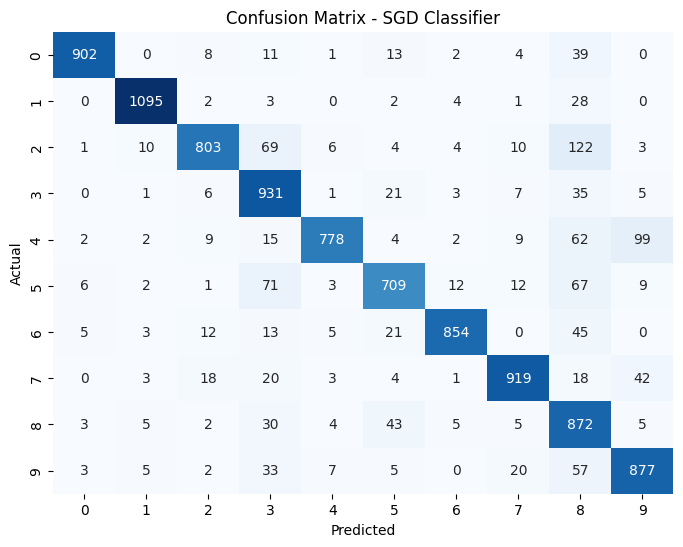

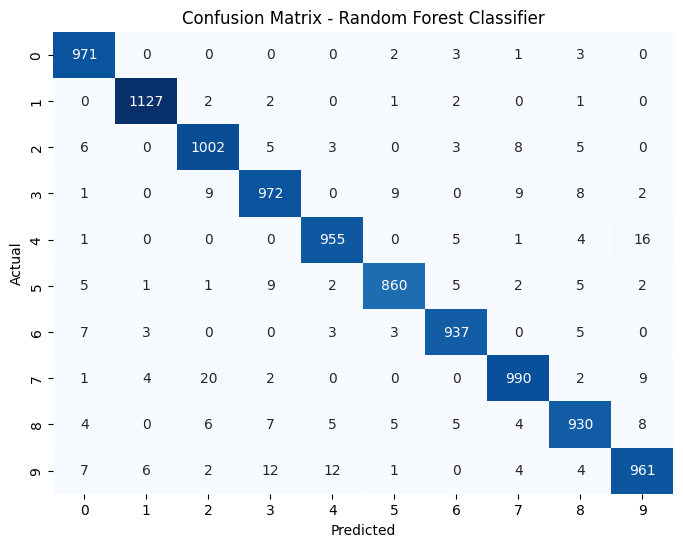

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_conf_matrix(cm_sgd, "SGD Classifier")
plot_conf_matrix(cm_rf, "Random Forest Classifier")


# **Visualize Worst Misclassifications**

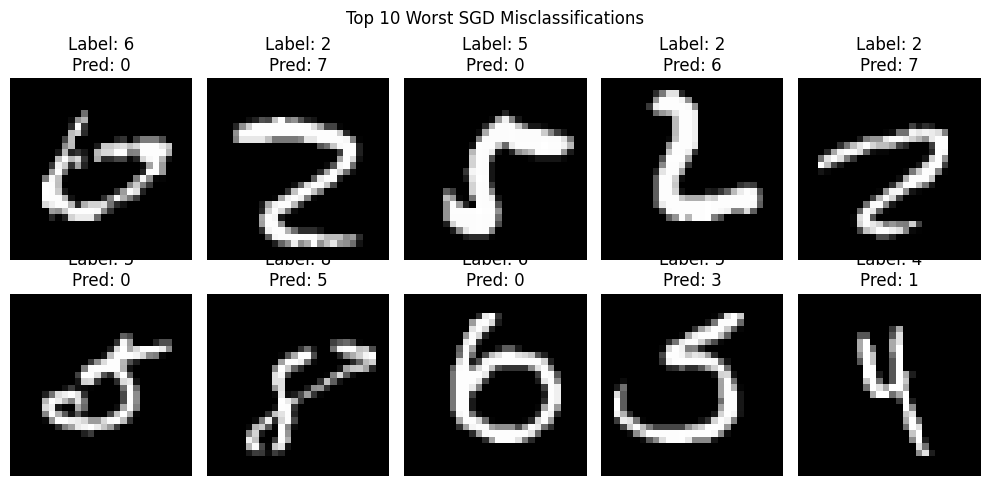

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get decision scores (for SGD only)
sgd_decision_scores = sgd_clf.decision_function(X_test)

# Identify misclassified samples
misclassified_idx = np.where(y_pred_sgd != y_test)[0]

# Compute confidence for wrong predictions (margin = abs score of wrong class)
confidences = np.max(sgd_decision_scores[misclassified_idx], axis=1)

# Get top 10 worst predictions (most confident wrong)
top_errors = misclassified_idx[np.argsort(-confidences)[:10]]

# Plot them
plt.figure(figsize=(10, 5))
for i, idx in enumerate(top_errors):
    image = X_test[idx].reshape(28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {y_test[idx]}\nPred: {y_pred_sgd[idx]}")
    plt.axis("off")
plt.suptitle("Top 10 Worst SGD Misclassifications")
plt.tight_layout()
plt.show()


# **Gradio Web App for MNIST Digit Recognition**

In [ ]:
# Install once in Colab
!pip install -q gradio scikit-image

import gradio as gr
import numpy as np
from PIL import Image, ImageOps
from skimage.transform import resize

def predict_digit(image):
    try:
        if not isinstance(image, np.ndarray):
            return {"error": "No drawing detected. Please draw a digit first."}

        print("Input shape:", image.shape)

        # Convert RGBA or RGB to grayscale
        if image.shape[-1] == 4:  # RGBA
            image = Image.fromarray(image[:, :, :3]).convert("L")
        else:
            image = Image.fromarray(image).convert("L")

        # Invert, resize to 28x28
        image = ImageOps.invert(image)
        image_resized = resize(np.array(image), (28, 28), mode="constant", anti_aliasing=False)

        # Flatten and scale
        image_flattened = image_resized.reshape(1, -1) * 255.0

        # Predict
        probs = rf_clf.predict_proba(image_flattened)[0]
        return {str(i): float(probs[i]) for i in range(10)}

    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

# Gradio interface using Sketchpad safely
interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST Digit Recognizer (Random Forest)",
    description="Draw a digit (0–9) and get top 3 predictions."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b73549718cc4773804.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
print(rf_clf.predict_proba([X_test[0]]))  # Should give a probability distribution


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
